a)

In [46]:
import gymnasium as gym

# (a) Create FrozenLake-v1 4x4 environment
env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=True)
print("Environment created:", env)


Environment created: <TimeLimit<OrderEnforcing<PassiveEnvChecker<FrozenLakeEnv<FrozenLake-v1>>>>>


b)

In [47]:
import numpy as np
import pandas as pd

EPISODES = 10000
data_log = []

def compute_goal_proximity(state):
    row, col = divmod(state, 4)
    return abs(3 - row) + abs(3 - col)

for episode in range(EPISODES):
    state, _ = env.reset()
    total_reward = 0
    episode_data = []
    while True:
        action = env.action_space.sample()
        next_state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        goal_prox = compute_goal_proximity(state)
        episode_data.append([state, action, reward, goal_prox])
        state = next_state
        if terminated or truncated:
            break
    for row in episode_data:
        row.append(total_reward)
        data_log.append(row)

df = pd.DataFrame(data_log, columns=["State", "Action", "Reward", "Goal_Proximity", "Total_Reward"])
print(df.head())


   State  Action  Reward  Goal_Proximity  Total_Reward
0      0       0     0.0               6           0.0
1      4       1     0.0               5           0.0
2      0       0     0.0               6           0.0
3      0       3     0.0               6           0.0
4      0       1     0.0               6           0.0


c)

In [49]:
success_episodes = df[df["Total_Reward"] == 1]["Total_Reward"].count()
success_rate = success_episodes / EPISODES
print(f"Random agent success rate: {success_rate:.4f}")


Random agent success rate: 0.2285


d)

In [50]:
df["Importance"] = df["Total_Reward"]
print(df.head())

   State  Action  Reward  Goal_Proximity  Total_Reward  Importance
0      0       0     0.0               6           0.0         0.0
1      4       1     0.0               5           0.0         0.0
2      0       0     0.0               6           0.0         0.0
3      0       3     0.0               6           0.0         0.0
4      0       1     0.0               6           0.0         0.0


e)

In [51]:
from sklearn.ensemble import RandomForestRegressor

X = df[["State", "Action", "Goal_Proximity"]]
y = df["Importance"]

rf_model = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf_model.fit(X, y)

print("Random Forest model trained successfully.")

Random Forest model trained successfully.


f)

In [52]:
import numpy as np

predict_cache = {}

def guided_agent(state):
    values = []
    for action in range(env.action_space.n):
        goal_prox = compute_goal_proximity(state)
        key = (state, action, goal_prox)
        if key in predict_cache:
            value = predict_cache[key]
        else:
            value = rf_model.predict([[state, action, goal_prox]])[0]
            predict_cache[key] = value
        values.append(value)
    return np.argmax(values)


g)

In [53]:
guided_success = []
for episode in range(EPISODES):
    state, _ = env.reset()
    total_reward = 0
    while True:
        action = guided_agent(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        state = next_state
        if terminated or truncated:
            break
    guided_success.append(total_reward)

guided_success_rate = np.mean(guided_success)
print(f"Guided agent success rate: {guided_success_rate:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

Guided agent success rate: 0.7341


h)

In [54]:
EPSILON = 0.1

def improved_agent(state):
    if np.random.rand() < EPSILON:
        return env.action_space.sample()
    else:
        return guided_agent(state)

improved_success = []
for episode in range(EPISODES):
    state, _ = env.reset()
    total_reward = 0
    while True:
        action = improved_agent(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        state = next_state
        if terminated or truncated:
            break
    improved_success.append(total_reward)

improved_success_rate = np.mean(improved_success)
print(f"Improved agent success rate: {improved_success_rate:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Improved agent success rate: 0.4061


In [ ]:
EPSILON_START = 1.0      # Start fully exploring
EPSILON_END = 0.1        # Minimum exploration
DECAY_RATE = 0.001       # Controls how quickly ε decays
MAX_STEPS = 100
improved_success = []
epsilon = EPSILON_START

for episode in range(EPISODES):
    state, _ = env.reset()
    total_reward = 0

    # Decay epsilon
    epsilon = EPSILON_END + (EPSILON_START - EPSILON_END) * np.exp(-DECAY_RATE * episode)

    for step in range(MAX_STEPS):
        if np.random.rand() < epsilon:
            action = env.action_space.sample()   # Explore
        else:
            action = guided_agent(state)         # Exploit

        next_state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        state = next_state

        if terminated or truncated:
            break

    improved_success.append(total_reward)

improved_success_rate = np.mean(improved_success)
print(f"Improved agent success rate: {improved_success_rate:.4f}")

Improved agent success rate: 0.3213


i)

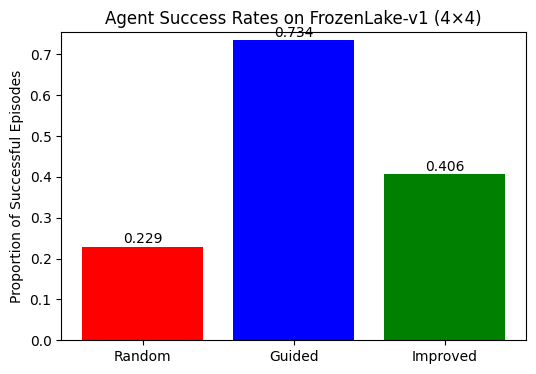

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
bars = plt.bar(
    ["Random", "Guided", "Improved"],
    [success_rate, guided_success_rate, improved_success_rate],
    color=['red', 'blue', 'green']
)
plt.title("Agent Success Rates on FrozenLake-v1 (4×4)")
plt.ylabel("Proportion of Successful Episodes")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.002, f"{yval:.3f}", ha='center', va='bottom')

plt.ylim(0, max(success_rate, guided_success_rate, improved_success_rate) + 0.02)
plt.show()
